# Taller 1 (Individual)

* Implementar los algoritmos de interpolación usando:
    * Nearest Neighbohr
    * Bilineal
    * Bicubico
    
Aumentar la resolución de la imagen en un número entero. Es decir $I \rightarrow NxN$, la imagen interpolada debe ser de tamaño $kN \times kN$ donde $k \in \mathbb Z$ y $k > 1$. 

**Fecha de entrega (11 feb)**

* Debe estar implementado en una gui, que sea fácil de usar:
    * Cargar la imagen.
    * Seleccionar k.
    * Mostrar la imagen original y la interpolada.

* Debe haber análisis de resultados

***Observe: Si desea ir a la parte interactiva de este notebook puede dirigirse hacia la penúltima celda, por otra parte si desea ver el código puede ir bajando celda a celda.*** 

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import clear_output
from os import listdir

(531, 531, 3)


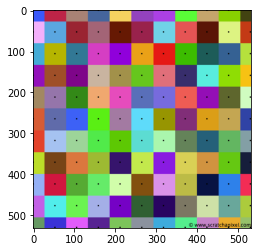

In [2]:
img = cv2.imread("./imgs/test_image.png")
#img = cv2.imread("./imgs/diomedes.jpg")
print(img.shape)
plt.imshow(img)

In [3]:
def izi_plot(img: np.ndarray, new_image: np.ndarray):
    
    fig, axs = plt.subplots(1, 2,  figsize=(15,12))
    axs[0].imshow(new_image)   
    axs[0].set_title("Imagen Reescalada")
    axs[1].imshow(img)
    axs[1].set_title("Imagen Original")
    plt.show()

## Resize usando nearest neighbor:



In [4]:

def resize_image_nearest_neighbor(img: np.ndarray, scaling: int):
    
    if scaling < 1:
        raise "scaling must be greater than 1!"
    
    # obtiene las dimensiones de la imagen inicial
    rows, cols, nchannels = img.shape
    
    # crea las dimensiones para la imagen reescalada
    new_rows = rows*scaling
    new_cols = cols*scaling
    
    # crea una matriz para la nueva imagen
    new_image = np.zeros((new_rows, new_cols, nchannels))

    # genero los indices de 1 hasta el numero nuevo de filas
    # y para que me quede en el rango de la imagen original 
    # divido función piso en el escalamiento
    
    row_idxs = np.int32( np.floor(np.arange(new_rows)/scaling) )
    col_idxs = np.int32( np.floor(np.arange(new_cols)/scaling) )

    
    for c in range(nchannels):
        
        # genero una variable temporal y me quedo solo con 
        # las filas requeridas del canal solicitado
        temp = img[row_idxs,:,c]
        
        # de las filas con las que me quedé 
        # paso a quedarme (y repetir) las columnas que 
        # corresponden
        new_image[:,:, c] = temp[:,col_idxs]
        
    #convierte la matriz a uint8 para poderla visualizar
    new_image = np.uint8(new_image)


    
    return new_image


Observe que las dimensiones de la imagen se ampliaron **(el rango en x e y del plot es más grande)**

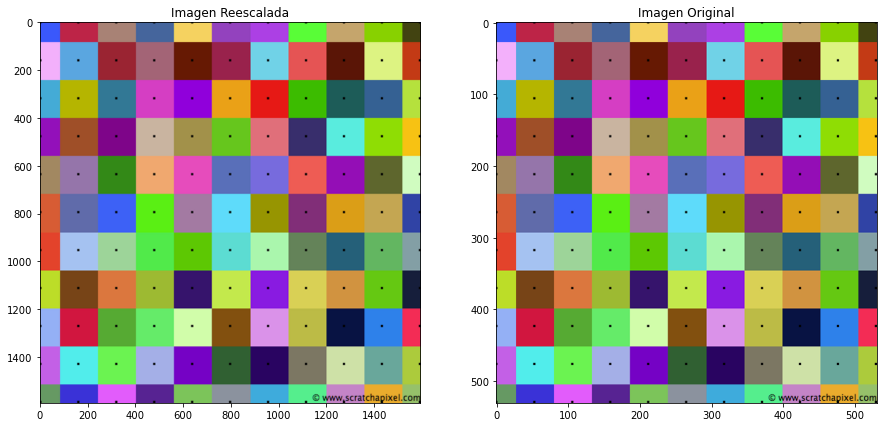

In [5]:
re_img_neighbor = resize_image_nearest_neighbor(img, 3)
izi_plot(img, re_img_neighbor)

## Resize usando interpolación bilineal:

 _Primero una versión serializada, después podremos analizar la versión vectorizada que corre mucho más rápido._

In [6]:
def bilineal_interp(dx, dy, c00, c01, c10, c11):
    
    a = ( c00 * (1 - dx) ) + c01 * dx
    b = ( c10 * (1 - dx) ) + c11 * dx

    return (a * (1 - dy) ) + b * dy
    

In [7]:
def resize_image_bilineal_interpolation(img: np.ndarray, scaling: int):
    
    if scaling < 1:
        raise "scaling must be greater than 1!"
    
    # obtiene las dimensiones de la imagen inicial
    rows, cols, nchannels = img.shape
    
    # crea las dimensiones para la imagen reescalada
    new_rows = rows*scaling
    new_cols = cols*scaling
    
    # crea una matriz para la nueva imagen
    new_image = np.zeros((new_rows, new_cols, nchannels))  
    
    # repite los bordes para poder hacer las operaciones más fácilmente
    img = cv2.copyMakeBorder(img, 1, 1, 1, 1, cv2.BORDER_REPLICATE)

    # primero observe que np.arange(new_rows)/new_rows corresponde 
    # a un vector de porcentajes, luego al multiplicar por el numero
    # de filas que hay en la imagen original estamos obteniendo 
    # la posición sobre la imagen original
    # (esta variable será util para generar indexados y dar pesos)
    absolute_row_idx = (np.arange(new_rows)* rows ) /new_rows
    absolute_col_idx = (np.arange(new_cols)* cols ) /new_cols

    # creamos los indices de los vecinos más cercanos
    row_idx_prev = np.int32(np.floor(absolute_row_idx))
    row_idx_next = row_idx_prev + 1 
    col_idx_prev = np.int32(np.floor(absolute_col_idx))
    col_idx_next = col_idx_prev + 1 
    
    # vector de distancias (que van a servir como pesos)
    dx = col_idx_next - absolute_col_idx
    dy = row_idx_next - absolute_row_idx
    
    for i in range(new_rows):
        for j in range(new_cols):
            for c in range(nchannels):
                new_image[i, j, c] = bilineal_interp(dx[j], dy[i],
                                                 img[row_idx_prev[i], col_idx_prev[j], c],
                                                 img[row_idx_prev[i], col_idx_next[j], c],
                                                 img[row_idx_next[i], col_idx_prev[j], c],
                                                 img[row_idx_next[i], col_idx_next[j], c])

               
    
    new_image = np.uint8(new_image)
    
    return new_image
    
            
            
    

In [8]:
#es muy lento, descomente para ejecutar
#re_img_bilinear = resize_image_bilineal_interpolation(img, 2)

In [9]:
#izi_plot(img, re_img_bilinear)

In [10]:
def resize_image_bilineal_interpolation2_one_channel(img: np.ndarray, scaling: int):
    
    if scaling < 1:
        raise "scaling must be greater than 1!"
    
    # obtiene las dimensiones de la imagen inicial
    nrows, ncols = img.shape
    
    # crea las dimensiones para la imagen reescalada
    new_nrows = nrows*scaling
    new_ncols = ncols*scaling
    
    # ratio de ampliación (se le resta uno por que 
    # en python se indexa desde 0)
    row_ratio = (nrows-1)/(new_nrows-1)
    col_ratio = (ncols-1)/(new_ncols-1)
        
    # aplana la imagen original
    img = img.ravel()

    # divmod retorna el cociente de la división y el residuo
    # en este caso el cociente corresponde a el número de fila 
    # y el residuo al número de columna en la matriz
    rows_idxs, cols_idxs = np.divmod(np.arange(new_nrows * new_ncols), new_ncols)

    # da las posiciones relativas en fila y columna
    # serán útiles para crear un indexado de vecinos
    # y asignar pesos, note que row_pos estará entre [0, nrows-1]
    rows_pos = rows_idxs * row_ratio
    cols_pos = cols_idxs * col_ratio
        
    # creamos los indices de los vecinos más cercanos
    row_prev = np.int32( np.floor(rows_pos) )
    row_next = np.int32( np.ceil(rows_pos)  )
    col_prev = np.int32( np.floor(cols_pos) )
    col_next = np.int32( np.ceil(cols_pos)  )

    row_weight = (rows_pos) - row_prev
    col_weight = (cols_pos) - col_prev
    
    img11 = img[row_prev*ncols + col_prev]
    img12 = img[row_prev*ncols + col_next]
    img21 = img[row_next*ncols + col_prev]
    img22 = img[row_next*ncols + col_next]
        
    local_img = img11 * (1 - col_weight) * (1 - row_weight) + \
                img12 * col_weight * (1 - row_weight) + \
                img21 * row_weight * (1 - col_weight) + \
                img22 * col_weight * row_weight

    new_image = local_img.reshape((new_nrows, new_ncols))
    new_image = np.uint8(new_image)
    
    return new_image
    
def resize_image_bilineal_interpolation2(img: np.ndarray, scaling: int):
    
    nrows, ncols, nchannels = img.shape
    new_img = np.zeros((nrows*scaling, ncols*scaling, nchannels))
    
    for c in range(nchannels):
        #new_img[:,:,c] = bilinear_resize_vectorized(img[:,:,c], nrows*scaling, ncols*scaling)
        new_img[:,:,c] = resize_image_bilineal_interpolation2_one_channel(img[:,:,c], scaling)  
        
    return new_img.astype("uint8")
    

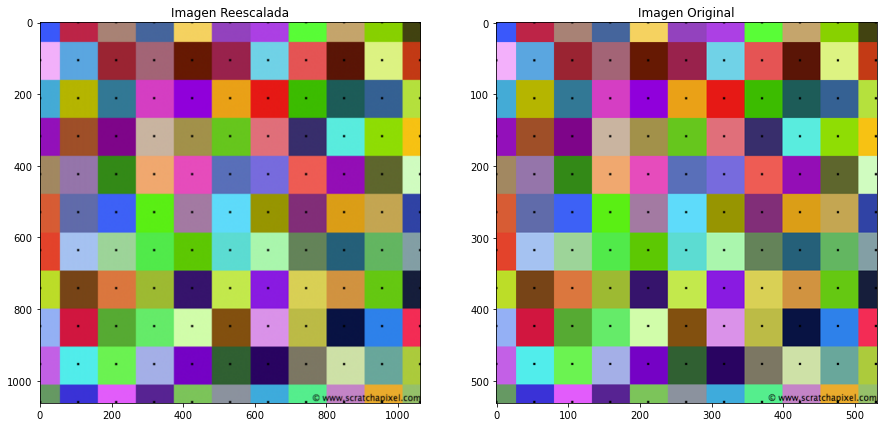

In [11]:
re_img_bilinear2 = resize_image_bilineal_interpolation2(img, 2)
izi_plot(img, re_img_bilinear2)

## Resize usando interpolación bicubica


In [12]:
def k2(x, a):
    
    """kernel de transformación de la interpolación bicubica"""
    
    #with magitude less than 2
    l1 = np.abs(x) <= 1
    
    # with magnitude between 1 and 2
    l2 = (np.abs(x) > 1) & (np.abs(x) < 2)
    
    # with magnitude greater than 2
    l3 = (np.abs(x) >= 2) 
    
    x[l1] = (a+2)*(np.abs(x[l1])**3) - (a+3)*(x[l1]**2) + 1
    x[l2] = ( a )*(np.abs(x[l2])**3) - (a*5)*(x[l2]**2) + 8*a*np.abs(x[l2]) - 4*a
    x[l3] = 0
    
    
    return x
    

In [13]:
def resize_image_bicubic_interpolation(img: np.ndarray, scaling: int, a: float):
    
    # obtiene las dimensiones de la imagen inicial
    nrows, ncols, nchannels = img.shape
    
    # crea las dimensiones para la imagen reescalada
    new_nrows = nrows*scaling
    new_ncols = ncols*scaling
    
    # crea la matriz de la imagen reescalada
    new_img = np.zeros((new_nrows, new_ncols, nchannels))
    
    # repite los bordes para poder hacer las operaciones más fácilmente
    img = cv2.copyMakeBorder(img, left=2, right=2, top=2, bottom=2, borderType = cv2.BORDER_REPLICATE)
    
    # obtiene un indexado de filas y columnas para 
    # la iamgen original
    rows_idxs, cols_idxs = np.divmod(np.arange(new_nrows*new_ncols), new_ncols)
    
    # para poner estos índices en la escala de indices 
    # de la matriz original, multiplicamos por los siguientes
    # factores de escalamiento 
    row_scaling = (nrows - 1)/(new_nrows - 1)
    col_scaling = (ncols - 1)/(new_ncols - 1)
    
    # ahora si ponemos los indices de filas y columnas 
    # en escala de la imagen original
    row_pos = (row_scaling * rows_idxs) + 2
    col_pos = (col_scaling * cols_idxs) + 2
    
    row_prev = np.floor(row_pos).astype('int32')
    col_prev = np.floor(col_pos).astype('int32')
    
    row1 = 1 + row_pos  - row_prev
    row2 =     row_pos  - row_prev
    row3 = 1 + row_prev - row_pos
    row4 = 2 + row_prev - row_pos
    
    col1 = 1 + col_pos  - col_prev
    col2 =     col_pos  - col_prev
    col3 = 1 + col_prev - col_pos
    col4 = 2 + col_prev - col_pos
    
    mat_l = np.array([[k2(col1, a), k2(col2, a), k2(col3, a), k2(col4, a) ]])
    #print("mat_l: ", mat_l[:,:].shape)
    
    mat_r = np.array([[k2(row1, a)], [k2(row2, a)], [k2(row3, a)], [k2(row4, a)]])
    #print("mat_r: ", mat_r.shape)
    
    for c in range(nchannels):
        mat_m = np.array([[img[(row_pos-row1).astype('int32'), (col_pos-col1).astype('int32'), c],
                            img[(row_pos-row2).astype('int32'), (col_pos-col1).astype('int32'), c],
                            img[(row_pos+row3).astype('int32'), (col_pos-col1).astype('int32'), c],
                            img[(row_pos+row4).astype('int32'), (col_pos-col1).astype('int32'), c]],
                            [img[(row_pos-row1).astype('int32'), (col_pos-col2).astype('int32'), c],
                             img[(row_pos-row2).astype('int32'), (col_pos-col2).astype('int32'), c],
                             img[(row_pos+row3).astype('int32'), (col_pos-col2).astype('int32'), c],
                             img[(row_pos+row4).astype('int32'), (col_pos-col2).astype('int32'), c]],
                            [img[(row_pos-row1).astype('int32'), (col_pos+col3).astype('int32'), c],
                             img[(row_pos-row2).astype('int32'), (col_pos+col3).astype('int32'), c],
                             img[(row_pos+row3).astype('int32'), (col_pos+col3).astype('int32'), c],
                             img[(row_pos+row4).astype('int32'), (col_pos+col3).astype('int32'), c]],
                            [img[(row_pos-row1).astype('int32'), (col_pos+col4).astype('int32'), c],
                             img[(row_pos-row2).astype('int32'), (col_pos+col4).astype('int32'), c],
                             img[(row_pos+row3).astype('int32'), (col_pos+col4).astype('int32'), c],
                             img[(row_pos+row4).astype('int32'), (col_pos+col4).astype('int32'), c]]])
    
    
    
        #print("mat_m: ", mat_m.shape)
    
        # esto se puede vectorizar
        # de pronto con tensordot, o con un 
        # np.multiply pero sinceramente traté 
        # y no me dió
        mat_lm = np.zeros((1, 4, new_nrows*new_ncols))
        for a in range(new_nrows*new_ncols):
            mat_lm[0, :, a] = np.dot(mat_l[:,:,a], mat_m[:,:,a])
    
        #print("mat_lm: ", mat_lm.shape)

        mat_lmr = np.zeros((1, new_ncols*new_nrows))
    
        for a in range(new_ncols*new_nrows):
            mat_lmr[:, a] = np.dot(mat_lm[:,:,a], mat_r[:,:,a])
    
        #print("mat_lmr: ", mat_lmr.shape)   

        new_img[:,:,c] = mat_lmr.reshape(new_nrows, new_ncols, ).astype("uint8")
    
    new_img = new_img.astype("uint8")
    
    return new_img
    
    

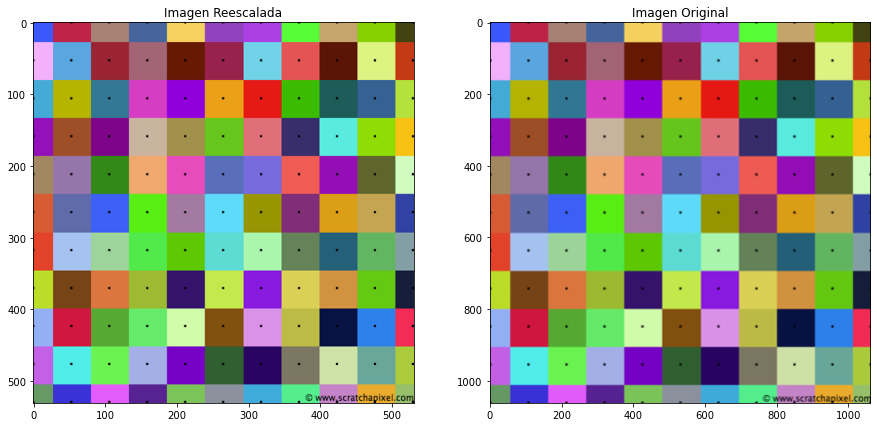

In [14]:
re_img_bicubic = resize_image_bicubic_interpolation(img, 2, 0.5)
izi_plot(re_img_bicubic, img)

In [15]:
# playground para ver si puedo vectorizar
# lo que está pasando dentro del 
# bilineal_interpolate

a = np.arange(20.).reshape(1,4,5)
b = np.arange(80.).reshape(4,4,5)
c = np.arange(20.).reshape(4,1,5)

mat_lm = np.zeros((1, 4, 5))

for t in range(5):
    mat_lm[0, :, t] = np.dot(a[:,:,t], b[:,:,t])

print("mat_lm: ", mat_lm.shape)

mat_lmr = np.zeros((1, 5))

for t in range(5):
    mat_lmr[:, t] = np.dot(mat_lm[:,:,t], c[:,:,t])

print("mat_lmr: ", mat_lmr.shape)


mat_lm:  (1, 4, 5)
mat_lmr:  (1, 5)


#### Sección de código para interfaz de usuario 

In [16]:
import io
from PIL import Image

In [17]:
style = {'description_width': 'initial'}


image_options = widgets.Dropdown(options = listdir("./imgs"),
                                 description = "Seleccione Imagen: ", 
                                 style = style
                                )

upload = widgets.FileUpload()

scaling = widgets.IntText(
    value=2,
    description='Factor de escalamiento:',
    disabled=False,
    style = style,
    layout= widgets.Layout(width='25%', height='100%')
)

a = widgets.widgets.FloatSlider(
                                value=0.5,
                                min=0,
                                max=1,
                                step=0.01,
                                description='Coeficiente del kernel (bicubico):',
                                disabled=False,
                                continuous_update=False,
                                orientation='horizontal',
                                readout=True,
                                readout_format='.2f',
                                style = style,
                                layout= widgets.Layout(width='50%', height='100%')
                            )

btn = widgets.Button(description='¡Visualizar Interplaciones!',
                     tooltip = 'Click me',
                     icon = 'check',
                     layout= widgets.Layout(width='50%', height='100%')
                    )

output = widgets.Output()


def _handle_upload(change):
    
    #print(upload.value.values())
    #print(list(upload.value.values())[0])
    
    for name, file_info in upload.value.items():
        
        print(name)
        img = Image.open(io.BytesIO(file_info['content']))
        img.save("./imgs/" + name)
    
    image_options.options = listdir("./imgs")
    #print(img)
        
    
    
upload.observe(_handle_upload, names='data')

In [18]:
def plot_as_requested(b):
    
    with output: 
        
        clear_output()
        plt.close('all') 
        plt.cla()
        plt.clf()

        print("./imgs/" + image_options.value)
        print("factor de escalamiento: ", scaling.value)
        print("coeficiente del kernel: ", a.value)
        print("Cargando ...")
        img = cv2.imread("./imgs/" + image_options.value)

        re_img_neighbor = resize_image_nearest_neighbor(img, scaling.value)
        re_img_bilinear = resize_image_bilineal_interpolation2(img, scaling.value)
        re_img_bicubic = resize_image_bicubic_interpolation(img, scaling.value, a.value)

        fig1, axs1 = plt.subplots(1, 2,  figsize=(15,15))
        axs1[0].imshow(re_img_neighbor)   
        axs1[0].set_title("Imagen Reescalada Vecinos Cercanos")
        axs1[1].imshow(img)
        axs1[1].set_title("Imagen Original")

        fig2, axs2 = plt.subplots(1, 2,  figsize=(15,15))
        axs2[0].imshow(re_img_bilinear)   
        axs2[0].set_title("Imagen Reescalada Iterp. Bilinear")
        axs2[1].imshow(img)
        axs2[1].set_title("Imagen Original")


        fig3, axs3 = plt.subplots(1, 2,  figsize=(15,15))
        axs3[0].imshow(re_img_bicubic)   
        axs3[0].set_title("Imagen Reescalada Iterp. Bicubica")
        axs3[1].imshow(img)
        axs3[1].set_title("Imagen Original")
        plt.show()
    
    

In [19]:
display(upload)
display(image_options)
display(scaling)
display(a)
display(btn, output)
btn.on_click(plot_as_requested)

FileUpload(value={}, description='Upload')

Dropdown(description='Seleccione Imagen: ', options=('butterfly2.jpg', 'diomedes2.jpg', 'diomedes.jpg', 'test_…

IntText(value=2, description='Factor de escalamiento:', layout=Layout(height='100%', width='25%'), style=Descr…

FloatSlider(value=0.5, continuous_update=False, description='Coeficiente del kernel (bicubico):', layout=Layou…

Button(description='¡Visualizar Interplaciones!', icon='check', layout=Layout(height='100%', width='50%'), sty…

Output()

## Conclusiones y análisis de resultados

De este ejercicio podemos concluir varias cosas entre ellas la superioridad en tiempos de computación que tienen las soluciones vectorizadas, en casos como las 2 implementaciones de interpolación bilineal que hay en este notebook lo pudimos notar directamente, sin embargo, en el proceso de desarrollo de este taller también hubo unas versiones seriales de la interpolación de vecinos más cercanos y bicubica _(tristemente estas han sido borradas)_, pero se llegó a ver largos tiempos de espera para obtener la imagen amplidada _(para la interpolación bicubica fueron tiempos superiores a los 10 min)_, colas tan largas para lograr el procesamiento de una imagen no son nada convenientes en una aplicación de deeplearning o machine learning donde se requiere preprocesar una buena cantidad de datos, de hecho esta tardanza puede afectar mucho el proceso de obtener resultados y ajustar los modelos. 


Respecto a los algoritmos de interpolación de las imágenes podemos notar que la interpolación de vecinos más cercanos no tiene un efecto mayor, es decir se limita a ampliar el tamaño de cada pixel varias veces, en contraste la interpolación bilineal tiene el efecto de suavizar ligeramente la imagen, le da una sensación un poco más borrosa y esto ocurre debido a que interpola linealmente entre puntos cercanos, este efecto se puede ver más claramente en los bordes de la imagen. En ese sentido hace que la imagen sea mucho más suave, porque de hecho tiene una derivada más suave en comparación con la interpolación de vecinos más cercanos, cuya derivada es más bien un conjunto de picos que tienden a infinito.

Finalmente podemos notar que la interpolación más suave de todas es la que proporciona la interpolación bicubica, y esto es porque usa un kernel con polinomio de grado 3 para hacer sus interpolaciones, este kernel no tiene solo primera derivada, sino también segunda lo que le da esa suavidad extra en comparación con la bilineal. Con la imagen _'./test_image.png'_ este efecto se puede ver más claramente en los bordes de cada recuadro, así como en el texto que aparece en la parte inferior derecha de la imagen, el cual se nota más borroso en comparación con la bilineal y la imagen original. 


### Referencias

* para contextualización [1](https://www.cambridgeincolour.com/tutorials/image-interpolation.htm) [2](https://en.wikipedia.org/wiki/Image_scaling#Algorithms)

* la idea para hacer esta interpolación de vecinos más cercanos viene de [aquí](https://www.imageeprocessing.com/2017/11/nearest-neighbor-interpolation.html)

* [Aquí se explica intuitivamente como funciona la interpolacion bilineal esta aproximación](https://theailearner.com/2018/12/29/image-processing-bilinear-interpolation/)

* [Acá también se explica el concepto de la interpolación bilineal y se muestra una implementación tentativa](https://www.scratchapixel.com/lessons/mathematics-physics-for-computer-graphics/interpolation/bilinear-filtering)
* [Implementación la vectorizada escribí en interpolación bilineal se guía por las fórmulas presentadas acá y el código](https://chao-ji.github.io/jekyll/update/2018/07/19/BilinearResize.html)
* Para crear la versión semi-vectorizada (vectoricé hasta más no poder) que desarrollé, me guié de códigos pasados y transformé [esta](https://www.geeksforgeeks.org/python-opencv-bicubic-interpolation-for-resizing-image/) versión serial que hace uso del kernel de transformación.